In [1]:
import sys
sys.path.append('..')
from CompoundPoisson2 import CompoundPoisson2
import time
import numpy as np
import scipy.stats as st
from SAABS import SA
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:

class SALoss2(SA):
    def __init__(self, X, c, gamma, K, t, init, epsilon, alpha):
        self.__alpha = alpha
        super(SALoss2, self).__init__(X, c, gamma, K, t, init, epsilon)
    
    @property
    def beta(self):
        return self.__beta
    
    @property
    def alpha(self):
        return self.__alpha
    
    def l(self, m):
        m = np.array(m)
        pos_part = np.maximum(0, m)
        sum_term = np.sum(m)
        square_term = np.sum(np.power(pos_part, 2))
        cross_term = 0
        for i in range(self.dim):
            for j in range(i + 1, self.dim):
                cross_term += pos_part[i] * pos_part[j]
        return sum_term + 0.5 * square_term + self.alpha * cross_term
        
    def grad(self, m):
        m = np.array(m)
        pos_part = np.maximum(0, m)
        sum_pos_part = np.sum(pos_part)
        #this is the vector of sum_{j != i} x_j^+
        pos_part_minus_xi = sum_pos_part - pos_part
        indic = np.sign(pos_part)
        cross_term = np.multiply(indic, pos_part_minus_xi)
        return np.ones(self.dim) + pos_part + self.alpha * cross_term

In [3]:
#Gaussian
#M is the length of the sample
#Change the following parameters to switch between the different cases

np.random.seed(seed=0)
M = 100000
#correlation between the gaussian distributions
corr = 0.9
#mu is the mean of the gaussian vector
mu = [0., 0.]
covariance = [[1., corr], [corr, 1.]]
rv = st.multivariate_normal(mean = mu, cov = covariance, allow_singular = True)
distr = rv.rvs(size = M)
#alpha is the systemic weight
alpha = 1.
#c, gamma of the SA
c, gamma  = 6., 1
#K the projection compact
K = [[0, 2], [0, 2], [0, 2]]
#t for the window of averaging
t = 10
#epsilon for the calculation of the approximation of the Jacobian matrix A
epsilon = 10 ** (-6)
#init is Z_0 of the SA
init = [0, 0, 0]
start_time = time.time()
loss = SALoss2(distr, c, gamma, K, t, init, epsilon, alpha)
#Z1 with gamma = 1
Z1 = loss.setRM()
print("Computation Time RM Algorithm: %s seconds ---" % (time.time() - start_time))
#Z0 with gamma = 0.7
gamma = 0.7
loss = SALoss2(distr, c, gamma, K, t, init, epsilon, alpha)
Z0 = loss.setRM()
print(Z0[:,-1])



Computation Time RM Algorithm: 4.205663681030273 seconds ---
[0.29518738 0.29085246 0.76499745]


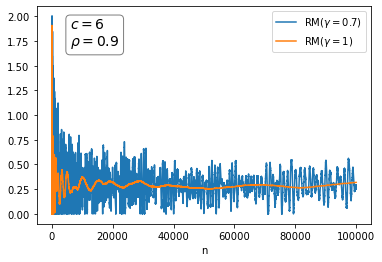

In [4]:
sample_size = [i for i in range(1, M + 1)]
fig, ax = plt.subplots()
textstr = '\n'.join((
    r'$c=%.f$' %(c, ),
    r'$\rho=%.1f$'%(corr, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.plot(sample_size, Z0[0], label = r'RM($\gamma = 0.7$)')
plt.plot(sample_size, Z1[0], label = r'RM($\gamma = 1$)')
plt.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.xlabel('n')
plt.legend()

In [5]:
#PR averaging
#estimation of Sigma* and the jacobian matrix A
loss.setEst()
zBar, CI = loss.getPR()
print(zBar)

[0.30733906 0.30701113 0.65188387]
